# Import required libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import pickle

# Load the churn dataset

In [2]:
df = pd.read_csv('/kaggle/input/churn-dataset/churn-bigml-80.csv')

# Step 1: Inspect dataset

In [3]:
print("Dataset Head:\n", df.head())
print("\nMissing Values:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes)
print("\nDataset Shape:\n", df.shape)

Dataset Head:
   State  Account length  Area code International plan Voice mail plan  \
0    KS             128        415                 No             Yes   
1    OH             107        415                 No             Yes   
2    NJ             137        415                 No              No   
3    OH              84        408                Yes              No   
4    OK              75        415                Yes              No   

   Number vmail messages  Total day minutes  Total day calls  \
0                     25              265.1              110   
1                     26              161.6              123   
2                      0              243.4              114   
3                      0              299.4               71   
4                      0              166.7              113   

   Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
0             45.07              197.4               99             16.78   
1      

# Step 2: Preprocess data

In [4]:
# Encode the binary target (Churn) to 0/1
df['Churn'] = df['Churn'].map({False: 0, True: 1})

In [5]:
# Select features (numerical and categorical) and target
features = ['Account length', 'Number vmail messages', 'Total day minutes', 'Total eve minutes',
            'Total night minutes', 'Total intl minutes', 'Customer service calls',
            'International plan', 'Voice mail plan']
X = df[features].copy() 
y = df['Churn']

In [6]:
# Encode categorical variables (International plan, Voice mail plan) to numerical
label_encoders = {}
for column in ['International plan', 'Voice mail plan']:
    label_encoders[column] = LabelEncoder()
    X.loc[:, column] = label_encoders[column].fit_transform(X[column])

In [7]:
# Standardize numerical features for better logistic regression performance
scaler = StandardScaler()
numerical_cols = ['Account length', 'Number vmail messages', 'Total day minutes', 'Total eve minutes',
                  'Total night minutes', 'Total intl minutes', 'Customer service calls']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [8]:
# Split into training (80%) and testing (20%) sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (2132, 9) (2132,)
Testing set shape: (534, 9) (534,)


# Step 3: Train Logistic Regression model

In [9]:
#logistic regression to predict churn with class weighting to address imbalance
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [10]:
# Predict on test set
y_pred = model.predict(X_test)  # Default threshold (0.5)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Step 4: Evaluation

In [11]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nModel Evaluation (Default Threshold 0.5):")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("\nConfusion Matrix (Default):\n", conf_matrix)


Model Evaluation (Default Threshold 0.5):
Accuracy: 0.7584269662921348
Precision: 0.3475609756097561
Recall: 0.7215189873417721

Confusion Matrix (Default):
 [[348 107]
 [ 22  57]]


# Step 5: Interpret coefficients and odds ratios

In [12]:
# Analyzing feature importance and odds ratios
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_[0],
    'Odds Ratio': np.exp(model.coef_[0])
})
print("\nCoefficients and Odds Ratios:\n", coefficients)


Coefficients and Odds Ratios:
                   Feature  Coefficient  Odds Ratio
0          Account length     0.043848    1.044823
1   Number vmail messages     0.325095    1.384162
2       Total day minutes     0.738946    2.093728
3       Total eve minutes     0.252958    1.287829
4     Total night minutes     0.164695    1.179033
5      Total intl minutes     0.225438    1.252872
6  Customer service calls     0.732560    2.080400
7      International plan     2.436676   11.434963
8         Voice mail plan    -1.572823    0.207459


# Step 6: Visualize ROC curve

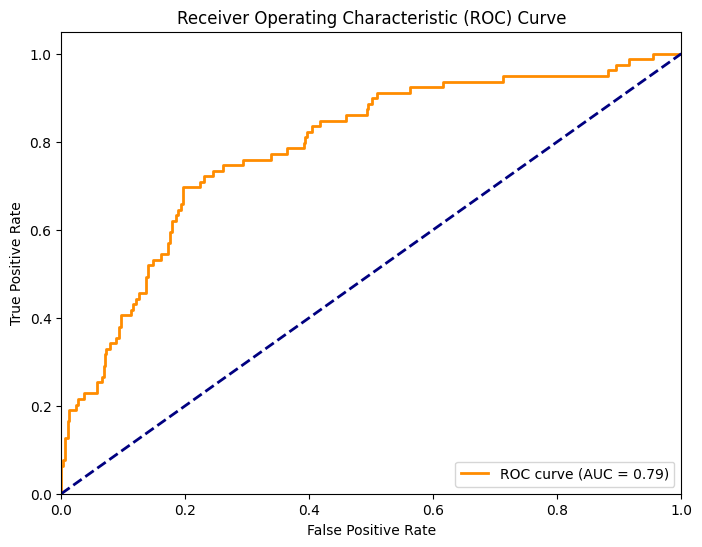

In [13]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('/kaggle/working/roc_curve.png')
plt.show()

# Step 7: Save model and predictions

In [14]:
# My note: Saving the trained model and predictions for submission
with open('/kaggle/working/logistic_model.pkl', 'wb') as f:
    pickle.dump(model, f)
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Probability': y_pred_prob}).to_csv('/kaggle/working/predictions_logistic.csv', index=False)

print("\nSaved: logistic_model.pkl, predictions_logistic.csv, roc_curve.png")


Saved: logistic_model.pkl, predictions_logistic.csv, roc_curve.png
